## SEIR Simulation 

In [1]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# load OD matrices
pkl_file = open('data/data_municipalities/od_municipalities.pkl', 'rb') # change to your desired directory
OD_matrices = pkl.load(pkl_file)
pkl_file.close()

print(OD_matrices.shape)

(84, 356, 356)


In [3]:
#kommunenummer = pd.read_csv("data/data_municipalities/kommuner.csv", delimiter=",").drop_duplicates()
#kommunenummer = kommunenummer.sort_values("Kommunenr. 2020", ascending=True).reset_index()[["Kommunenr. 2020", "Kommunenavn 2020"]]
#kommunenummer.rename(columns={"Kommunenr. 2020": "kommune_id", "Kommunenavn 2020": "kommunenavn"}, inplace=True)
#kommunenummer.kommune_id = kommunenummer.kommune_id.astype(int)

# create population 
befolkningstall_kommuner = pd.read_csv("data/data_municipalities/Folkemengde_kommuner.csv", delimiter=";", skiprows=1)
kommune_id = []
kommune_navn = []
for id_name in befolkningstall_kommuner.region.str.split(" "):
    kommune_id.append(int(id_name[0]))
    kommune_navn.append(str(id_name[1]))
befolkningstall_kommuner["kommune_id"] = kommune_id
befolkningstall_kommuner["kommunenavn"] = kommune_navn

befolkningstall_kommuner = befolkningstall_kommuner[["kommune_id", "kommunenavn", "Befolkning per 1.1. (personer) 2020"]]
befolkningstall_kommuner = befolkningstall_kommuner.rename(columns={ "Befolkning per 1.1. (personer) 2020": "befolkning"})

In [5]:
befolkningsarray = befolkningstall_kommuner.befolkning.to_numpy(dtype='float64')
pop = np.asarray([befolkningsarray for _ in range(84)])

In [6]:
print(len(befolkningsarray))

356


In [7]:
# Set up model 
%run virus-sim.py  # Call python files in same directory

r = OD_matrices.shape[0]  # Simulation period (e.g 84)
n = pop.shape[1]          # Number of counties (e.g 11)
N = sum(befolkningsarray) # Total population (e.g 5367580)
initialInd = [2]          # Initial index of counties infected
initial = np.zeros(n)
initial[initialInd] = 50  # Number of infected people in each of the initial counties infected

model = Param(R0=2.4, DE= 5.6 * 12, DI= 5.2 * 12, I0=initial, HospitalisationRate=0.1, eff=0.95, HospitalIters=15*12) # multiply by 12 as one day consists of 12 2-hours periods 

In [8]:
# load vaccine schedule
pkl_file = open('data/data_municipalities/vaccines_municipalities.pkl', 'rb')
vacc = pickle.load(pkl_file)
pkl_file.close()
print(vacc.shape)

(84, 356)


In [9]:
# run simulation
%run virus-sim.py

alphas = [np.ones(OD_matrices.shape) for x in range(4)]  # One == no quarantene influence. Multiplied by real flow.
iterations = 3000                   # Number of simulations
res = {}                            # Dictionary with results for different cases 
inf = 50                            # Number of random infections
res['baseline'] = seir(model, pop, OD_matrices, alphas, iterations, inf, vacc)


In [10]:
# Print hospitalized information
print("Max number of hospitalised people: ", int(res["baseline"][0][:,4].max()))
print("Day with max hospitalised people: ", int(res["baseline"][0][:,4].argmax()/12)) # Divide by

Max number of hospitalised people:  62423
Day with max hospitalised people:  57


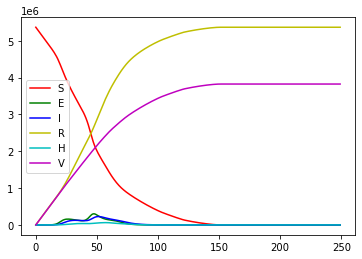

In [11]:
def seir_plot(res):
    """ Plots the epidemiological curves
    Parameters:
    res: [3D array, compartment_id]
    """
    plt.plot(res[::12, 0], color='r', label='S')
    plt.plot(res[::12, 1], color='g', label='E')
    plt.plot(res[::12, 2], color='b', label='I')
    plt.plot(res[::12, 3], color='y', label='R')
    plt.plot(res[::12, 4], color='c', label='H')
    plt.plot(res[::12, 5], color='m', label='V')
    plt.legend()
    plt.show()
    
seir_plot(res["baseline"][0])

## Spatial Visualisation

In [12]:
# import libraries
import pandas as pd
import geopandas as gpd
# import contextily as ctx # Is not installed with current .yml file 
import fiona as fi
from pyproj import CRS

In [13]:
kommuner = pd.read_json('data/data_municipalities/Basisdata_0000_Norge_25833_Kommuner_GEOJSON.geojson')
epsg_kommune = int(kommuner["administrative_enheter.kommune"].loc["crs"]["properties"]["name"].split(":")[1]) # epsg for kartverket sin data
crs_kommune = CRS.from_epsg(epsg_kommune)

In [14]:
# Load data and ensure right epsg
norge_geojson = gpd.read_file("data/data_municipalities/Basisdata_0000_Norge_25833_Kommuner_GEOJSON.geojson", layer='administrative_enheter.kommune')
norge_geojson.crs = {'init':f'epsg:{epsg_kommune}'}
norge_geojson.crs = crs_kommune
norge_geojson.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 363 entries, 0 to 362
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   objtype                   363 non-null    object  
 1   samiskforvaltningsomrade  350 non-null    object  
 2   lokalid                   363 non-null    object  
 3   navnerom                  363 non-null    object  
 4   versjonid                 363 non-null    object  
 5   datafangstdato            0 non-null      object  
 6   oppdateringsdato          363 non-null    object  
 7   datauttaksdato            363 non-null    object  
 8   opphav                    0 non-null      object  
 9   kommunenummer             363 non-null    object  
 10  navn                      363 non-null    object  
 11  geometry                  363 non-null    geometry
dtypes: geometry(1), object(11)
memory usage: 34.2+ KB
C:\Users\Peder\Anaconda3\envs\epidemics_2\lib\si

In [15]:
norge_geojson = norge_geojson.drop_duplicates(['kommunenummer']).reset_index()

In [16]:
#norge_geojson = norge_geojson[norge_geojson.duplicated(['kommunenummer'], keep=False)]
norge_geojson.sort_values(['kommunenummer'], ascending = True)

,index,objtype,samiskforvaltningsomrade,lokalid,navnerom,versjonid,datafangstdato,oppdateringsdato,datauttaksdato,opphav,kommunenummer,navn,geometry
227,232,Kommune,False,173018,https://data.geonorge.no/sosi/administrativeen...,4.1,None,20200207000000,20210104100705,None,0301,"[ { ""navn"": ""Oslo"", ""rekkefolge"": """", ""sprak"":...","POLYGON ((253222.080 6658210.130, 253240.670 6..."
151,154,Kommune,False,173102,https://data.geonorge.no/sosi/administrativeen...,4.1,None,20200207000000,20210104100703,None,1101,"[ { ""navn"": ""Eigersund"", ""rekkefolge"": """", ""sp...","POLYGON ((-32368.950 6519591.960, -32374.980 6..."
310,315,Kommune,False,173091173075173090,https://data.geonorge.no/sosi/administrativeen...,4.1,None,20200917000000,20210104100708,None,1103,"[ { ""navn"": ""Stavanger"", ""rekkefolge"": """", ""sp...","POLYGON ((-42633.160 6593087.740, -40878.870 6..."
335,341,Kommune,False,173100,https://data.geonorge.no/sosi/administrativeen...,4.1,None,20200207000000,20210104100709,None,1106,"[ { ""navn"": ""Haugesund"", ""rekkefolge"": """", ""sp...","POLYGON ((-69037.300 6632413.420, -63419.960 6..."
311,316,Kommune,False,173083173078,https://data.geonorge.no/sosi/administrativeen...,4.1,None,20190304000000,20210104100708,None,1108,"[ { ""navn"": ""Sandnes"", ""rekkefolge"": """", ""spra...","POLYGON ((-1895.270 6572773.840, -4840.330 657..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,212,Kommune,False,173052,https://data.geonorge.no/sosi/administrativeen...,4.1,None,20200207000000,20210104100704,None,5440,"[ { ""navn"": ""Berlevåg"", ""rekkefolge"": """", ""spr...","POLYGON ((998634.270 7930000.890, 997438.460 7..."
295,300,Kommune,None,172717,https://data.geonorge.no/sosi/administrativeen...,4.1,None,20200207000000,20210104100707,None,5441,"[ { ""navn"": ""Tana"", ""rekkefolge"": ""2"", ""sprak""...","POLYGON ((961748.280 7852517.620, 961864.240 7..."
251,256,Kommune,None,172922,https://data.geonorge.no/sosi/administrativeen...,4.1,None,20200207000000,20210104100705,None,5442,"[ { ""navn"": ""Nesseby"", ""rekkefolge"": ""2"", ""spr...","POLYGON ((1000896.830 7843608.070, 1000722.360..."
341,347,Kommune,False,173053,https://data.geonorge.no/sosi/administrativeen...,4.1,None,20200207000000,20210104100710,None,5443,"[ { ""navn"": ""Båtsfjord"", ""rekkefolge"": """", ""sp...","POLYGON ((1033119.220 7899727.540, 1033235.300..."


In [17]:
norge_geojson.crs

<Projected CRS: EPSG:25833>
Name: ETRS89 / UTM zone 33N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe - 12°E to 18°E and ETRS89 by country
- bounds: (12.0, 46.4, 18.01, 84.01)
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [18]:

norge_geojson_3857 = norge_geojson.to_crs(epsg=3857)  # Convert to epsg=3857 to use contextily
west, south, east, north = norge_geojson_3857.unary_union.bounds

In [19]:
# declare baseline array storing the dynamics of the compartments 
baseline = res['baseline'][1][::12, :, :]
print(baseline.shape)
print(baseline)

(250, 6, 356)
[[[3.13730000e+04 4.92730000e+04 5.66820000e+04 ... 9.26000000e+02
   2.22100000e+03 1.01580000e+04]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 5.00000000e+01 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[4.16437950e+04 5.18777276e+04 6.05532502e+04 ... 2.98579788e+03
   4.55142770e+03 5.30901574e+03]
  [3.04279868e+00 4.58590266e+00 5.43736659e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [6.04731985e+00 9.55661080e+00 1.14909031e+01 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [1.22289473e+02 1.30625599e+02 1.28685411e+02 ... 1.26297593e+02
   1.286

In [20]:
# declare hopsitalisation array storing the dynamics of the hospitalised 
hosp = res['baseline'][0][::12, 4]
print(hosp.shape)
print(hosp)

(250,)
[0.00000000e+00 1.20984504e-01 5.61350200e-01 1.27630811e+00
 2.28419258e+00 3.66683690e+00 5.59138776e+00 8.36125291e+00
 1.25072231e+01 1.89458747e+01 2.92532624e+01 4.61349206e+01
 7.42249082e+01 1.21419944e+02 2.01034286e+02 3.35070776e+02
 5.58492525e+02 9.23707409e+02 1.50193108e+03 2.37444432e+03
 3.61082260e+03 5.24212182e+03 7.24838233e+03 9.56899186e+03
 1.21236498e+04 1.48297561e+04 1.76124587e+04 2.04087053e+04
 2.31667556e+04 2.58423512e+04 2.83927133e+04 3.07694853e+04
 3.29122658e+04 3.47463236e+04 3.61905421e+04 3.71794253e+04
 3.76909506e+04 3.77611482e+04 3.74772035e+04 3.69615299e+04
 3.63604059e+04 3.58385813e+04 3.55738853e+04 3.57454816e+04
 3.65123974e+04 3.79780490e+04 4.01363101e+04 4.28316416e+04
 4.58021958e+04 4.87890737e+04 5.16103840e+04 5.41671049e+04
 5.64178365e+04 5.83493655e+04 5.99516354e+04 6.12009291e+04
 6.20483524e+04 6.24159227e+04 6.22055088e+04 6.13203286e+04
 5.97017834e+04 5.73852858e+04 5.45421437e+04 5.14382690e+04
 4.83263220e+04 4

In [21]:
# find maximum hospitalisation value to make sure the color intensities in the animation are anchored against it
max_exp_ind = np.where(baseline[:, 1, :] == baseline[:, 1, :].max())[0].item()
max_exp_val = baseline[:, 1, :].max()
print(max_exp_ind, max_exp_val)

47 18270.72438712496


(256, 4)
[[1.         0.96078431 0.94117647 1.        ]
 [0.99987697 0.95820069 0.93748558 1.        ]
 [0.99975394 0.95561707 0.93379469 1.        ]
 ...
 [0.41917724 0.00369089 0.05294887 1.        ]
 [0.4115494  0.00184544 0.05196463 1.        ]
 [0.40392157 0.         0.05098039 1.        ]]


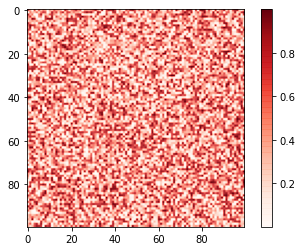

In [22]:
ncolors = 256
# get cmap
color_array = plt.get_cmap('Reds')(range(ncolors))
print(color_array.shape)
print(color_array)

# change alpha values
color_array[:, -1] = np.linspace(0.3, 1, ncolors)

# create colormap object
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap

map_object = LinearSegmentedColormap.from_list(name="Reds_transp", colors=color_array)

# register the colormap object
plt.register_cmap(cmap=map_object)

# plot some example data
fig, ax = plt.subplots()
h = ax.imshow(np.random.rand(100,100), cmap='Reds_transp')
plt.colorbar(mappable=h)

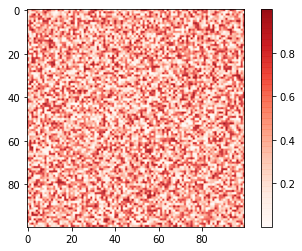

In [23]:
def trunc_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list('trunc({n}, {a:.2f}, {b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
                                                cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('Reds_transp')
new_cmap = trunc_colormap(cmap, 0.0, .9)

# plot some example data
fig, ax = plt.subplots()
h = ax.imshow(np.random.rand(100,100), cmap=new_cmap)
plt.colorbar(mappable=h)

In [24]:
params = {"axes.labelcolor":"slategrey"}
plt.rcParams.update(params)
cmap = plt.cm.get_cmap("Blues")
blue = cmap(200)

from tqdm import tqdm

# Used for colorbar 
max_exp_val = baseline[:, 1, :].max()
min_exp_val = baseline[:, 1, :].min()
h = ax.imshow(np.random.uniform(low=min_exp_val, high=max_exp_val, size=(10,10)), cmap=new_cmap)

for time_step in tqdm(range(1,100)):
    
    norge_geojson_3857['exposed'] = baseline[time_step-1, 1, :]
    
    #plot
    fig, ax = plt.subplots(figsize=(14,14), dpi=72)
    norge_geojson_3857.loc[norge_geojson_3857.index==84, 'exposed'] = max_exp_val + 1
    norge_geojson_3857.plot(ax=ax, facecolor='none', edgecolor='gray', alpha=0.5, linewidth=0.5, zorder=2)
    norge_geojson_3857.plot(ax=ax, column='exposed', cmap=new_cmap, zorder=3)
    # add background
    # ctx.add_basemap(ax, attribution="", source=ctx.sources.ST_TONER_LITE, zoom='auto', alpha=0.6)
    
    ax.set_xlim(west, east)
    ax.set_ylim(south, north)
    ax.axis('off')
    plt.tight_layout()

    # Add colourbar
    plt.colorbar(mappable=h)
    
    inset_ax = fig.add_axes([0.4, 0.14, 0.37, 0.27])
    inset_ax.patch.set_alpha(0.5)
    
    inset_ax.plot(baseline[:time_step, 0].sum(axis=1), label="susceptible", color=blue, ls='-', lw=1.5, alpha=0.8)
    inset_ax.plot(baseline[:time_step, 1].sum(axis=1), label="exposed", color='g', ls='-', lw=1.5, alpha=0.8)
    inset_ax.plot(baseline[:time_step, 2].sum(axis=1), label="infectious", color='r', ls='-', lw=1.5, alpha=0.8)
    inset_ax.plot(baseline[:time_step, 3].sum(axis=1), label="recovered", color='y', ls='-', lw=1.5, alpha=0.8)
    inset_ax.plot(hosp[:time_step], label="hospitalised", color='purple', ls='-', lw=1.5, alpha=0.8)
    inset_ax.plot(baseline[:time_step, 5].sum(axis=1), label="vaccinated", color='m', ls='-', lw=1.5, alpha=0.8)
    
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 0].sum(), color=blue, s=50, alpha=0.2)
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 1].sum(), color='g', s=50, alpha=0.2)
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 2].sum(), color='r', s=50, alpha=0.2)
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 3].sum(), color='y', s=50, alpha=0.2)
    inset_ax.scatter((time_step-1), hosp[(time_step-1)], color='purple', s=50, alpha=0.2)
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 5].sum(), color='m', s=50, alpha=0.2)
    
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 0].sum(), color=blue, s=20, alpha=0.8)
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 1].sum(), color='g', s=20, alpha=0.8)
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 2].sum(), color='r', s=20, alpha=0.8)
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 3].sum(), color='y', s=20, alpha=0.8)
    inset_ax.scatter((time_step-1), hosp[(time_step-1)], color='purple', s=20, alpha=0.8)
    inset_ax.scatter((time_step-1), baseline[(time_step-1), 5].sum(), color='m', s=20, alpha=0.8)
    
    inset_ax.fill_between(np.arange(0, time_step), np.maximum(baseline[:time_step, 0].sum(axis=1), \
                                                             baseline[:time_step, 3].sum(axis=1)), alpha=0.035, color='r')
    inset_ax.plot([time_step, time_step], [0, max(baseline[(time_step-1), 0].sum(), \
                                              baseline[(time_step-1), 3].sum())], ls='--', lw=0.7, alpha=0.8, color='r')
    
    inset_ax.set_ylabel('Population', size=18, alpha=1, rotation=90)
    inset_ax.set_xlabel('Days', size=18, alpha=1)
    inset_ax.yaxis.set_label_coords(-0.15, 0.55)
    inset_ax.tick_params(direction='in', size=10)
    inset_ax.set_xlim(-4, 254)
    inset_ax.set_ylim(-24000, 6024000)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    inset_ax.grid(alpha=0.4)
    
    inset_ax.spines['right'].set_visible(False)
    inset_ax.spines['top'].set_visible(False)
    
    inset_ax.spines['left'].set_color('darkslategrey')
    inset_ax.spines['bottom'].set_color('darkslategrey')
    inset_ax.tick_params(axis='x', colors='darkslategrey')
    inset_ax.tick_params(axis='y', colors='darkslategrey')
    plt.legend(prop={'size':14, 'weight':'light'}, framealpha=0.5)
    plt.title("Norway Covid-19 spreading on day: {}".format(time_step), fontsize=18, color= 'dimgray')
    plt.savefig("plots/plots_municipalities/flows_{}.jpg".format(time_step), dpi=fig.dpi)
    plt.close()

100%|██████████| 99/99 [09:39<00:00,  5.86s/it]


In [25]:
import re

def sort_in_order( l ):
    """ sorts a given iterable
    
    l : iterable to be sorted"""
    
    convert = lambda text: int(text) if text.isdigit() else text
    alphanumeric_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanumeric_key)

from os import listdir

filenames = listdir("plots/plots_municipalities/")
filenames = sort_in_order(filenames)
print(filenames)

['flows_1.jpg', 'flows_2.jpg', 'flows_3.jpg', 'flows_4.jpg', 'flows_5.jpg', 'flows_6.jpg', 'flows_7.jpg', 'flows_8.jpg', 'flows_9.jpg', 'flows_10.jpg', 'flows_11.jpg', 'flows_12.jpg', 'flows_13.jpg', 'flows_14.jpg', 'flows_15.jpg', 'flows_16.jpg', 'flows_17.jpg', 'flows_18.jpg', 'flows_19.jpg', 'flows_20.jpg', 'flows_21.jpg', 'flows_22.jpg', 'flows_23.jpg', 'flows_24.jpg', 'flows_25.jpg', 'flows_26.jpg', 'flows_27.jpg', 'flows_28.jpg', 'flows_29.jpg', 'flows_30.jpg', 'flows_31.jpg', 'flows_32.jpg', 'flows_33.jpg', 'flows_34.jpg', 'flows_35.jpg', 'flows_36.jpg', 'flows_37.jpg', 'flows_38.jpg', 'flows_39.jpg', 'flows_40.jpg', 'flows_41.jpg', 'flows_42.jpg', 'flows_43.jpg', 'flows_44.jpg', 'flows_45.jpg', 'flows_46.jpg', 'flows_47.jpg', 'flows_48.jpg', 'flows_49.jpg', 'flows_50.jpg', 'flows_51.jpg', 'flows_52.jpg', 'flows_53.jpg', 'flows_54.jpg', 'flows_55.jpg', 'flows_56.jpg', 'flows_57.jpg', 'flows_58.jpg', 'flows_59.jpg', 'flows_60.jpg', 'flows_61.jpg', 'flows_62.jpg', 'flows_63.jpg', 

In [27]:
import imageio
from tqdm import tqdm
with imageio.get_writer('gifs/gifs_municipalities/Covid_19_municipalities.gif', mode='I', fps=4) as writer:
    for filename in tqdm(filenames):
        image = imageio.imread('plots/plots_municipalities/{}'.format(filename))
        writer.append_data(image)

100%|██████████| 99/99 [00:33<00:00,  2.93it/s]
